# Introduction
In our extension of the Linguistic Harbingers of Betrayal paper, we reproduce the features used by the authors and use different machine learning models to compare their performance when predicting betrayal. We also consider new features: the amount of support provided by the victim and the betrayer, as well as aggregates of the features to characterize each friendship with their mean and variance. We ask ourselves whether these new features are relevant when trying to predict betrayal, and we train different machine learning models with them. 

In [1]:
# Import the required libraries
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from features_helper import *
from plot_helper import *
from training_helper import *

# Init the style for the plots
init_style()

In [2]:
data_path = 'data/diplomacy_data.json'

# Load the json data
with open(data_path) as data_file:
    data_json = json.load(data_file)

# 1. Feature Processing

In [3]:
# Get the last friendly action for each friendship
last_friendly_action = get_last_friendly_action(data_json)

To reproduce the features used in the paper, we computed the mean value of all the message features in a season, resulting in a list of season features. Some of the message information were stored as a list of words such as the temporal feature, we chose to replace them by the number of words in each list. Some of these lists were defined as N/A, we then assumed that they contained no words, and thus assigned them a value of $0$. In addition to the messages features, we also added two new features: the number of messages and the support: whether each player supported the other in the season (1 if it is true and 0 if not). All of theses features exist twice, as they are a property of the player type: the victim or the betrayer.

In [4]:
# Load the season feature for each player type and concat them
season_features_victim = load_season_features(data_json, last_friendly_action, 'victim')
season_features_betrayer = load_season_features(data_json, last_friendly_action, 'betrayer')
season_features = pd.concat([season_features_victim, season_features_betrayer])
season_features.head()

,idx,season,betrayal,support,n_requests,n_words,politeness,n_sentences,sentiment.positive,sentiment.neutral,...,premise,expansion,comparison,planning,claim,temporal,contingency,last_season,n_messages,player_type
0,0,1906.5,True,1,3.250000,120.000000,0.809993,7.750000,1.500000,1.250000,...,4.750000,1.0,1.250000,1.000000,0.500000,1.250000,0.250000,1909.0,4,victim
1,0,1907.0,True,0,0.666667,31.000000,0.785508,3.000000,1.333333,0.666667,...,0.333333,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1909.0,3,victim
2,0,1907.5,True,0,3.666667,120.000000,0.607331,9.333333,1.000000,3.666667,...,2.000000,1.0,0.333333,0.333333,0.000000,0.000000,0.333333,1909.0,3,victim
3,0,1908.0,True,0,0.500000,28.000000,0.571134,3.000000,1.000000,0.000000,...,1.000000,1.0,0.500000,1.000000,0.500000,0.500000,0.500000,1909.0,2,victim
4,0,1908.5,True,0,2.333333,85.333333,0.563423,5.000000,0.666667,1.666667,...,1.000000,1.0,0.000000,0.666667,0.333333,0.333333,0.000000,1909.0,3,victim


In [5]:
# Compute the features corresponding the paper features

# Merge the features from the two player types of the same season together
# Remove the support the information as it was not used in the paper
final_season_features = merge_player_features(season_features.drop(columns=['last_season', 'support']), on=['idx', 'season', 'betrayal'])
final_season_features['betrayal'] = final_season_features['betrayal'].astype(int) # Convert the betrayal into an integer
final_season_features = final_season_features.drop(columns=['idx', 'season']) # No need to identify the season anymore
final_season_features.head()

,betrayal,n_requests_victim,n_words_victim,politeness_victim,n_sentences_victim,sentiment.positive_victim,sentiment.neutral_victim,sentiment.negative_victim,subjectivity_victim,premise_victim,...,sentiment.negative_betrayer,subjectivity_betrayer,premise_betrayer,expansion_betrayer,comparison_betrayer,planning_betrayer,claim_betrayer,temporal_betrayer,contingency_betrayer,n_messages_betrayer
0,1,3.250000,120.000000,0.809993,7.750000,1.500000,1.250000,5.000000,17.000000,4.750000,...,1.500000,15.333333,1.166667,1.000000,1.000000,0.500000,0.166667,0.500000,0.333333,6
1,1,0.666667,31.000000,0.785508,3.000000,1.333333,0.666667,1.000000,4.666667,0.333333,...,1.285714,4.857143,0.428571,0.285714,0.142857,0.285714,0.142857,0.142857,0.285714,7
2,1,3.666667,120.000000,0.607331,9.333333,1.000000,3.666667,4.666667,14.666667,2.000000,...,2.000000,28.500000,1.000000,2.500000,2.000000,2.000000,2.000000,2.000000,3.500000,2
3,1,0.500000,28.000000,0.571134,3.000000,1.000000,0.000000,2.000000,5.500000,1.000000,...,2.200000,16.400000,1.200000,1.800000,0.600000,1.000000,0.200000,1.000000,1.200000,5
4,1,2.333333,85.333333,0.563423,5.000000,0.666667,1.666667,2.666667,9.333333,1.000000,...,1.000000,9.500000,1.000000,1.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2


We considered features characterizing each friendship. To this end, we aggregated the features of all messages of each friendship, and computed their means and variances. \
In some friendships, one of the players never sent any messages and as a consequence did not have any season features associated with them. We removed these friendships, as they had only information about one of the two players.

In [6]:
# Compute the friendship features from the season ones
friendship_features = get_friendship_features(season_features)
friendship_features.head()

,idx,player_type,betrayal,mean_support,mean_n_requests,mean_n_words,mean_politeness,mean_n_sentences,mean_sentiment.positive,mean_sentiment.neutral,...,var_sentiment.negative,var_subjectivity,var_premise,var_expansion,var_comparison,var_planning,var_claim,var_temporal,var_contingency,var_n_messages
0,0,betrayer,True,1.000000,2.830952,75.411111,0.792530,3.792063,1.046032,1.192857,...,0.174455,61.610330,0.118698,0.617312,0.507596,0.420068,0.506428,0.457751,1.444826,3.805556
1,0,victim,True,0.166667,2.069444,72.972222,0.685290,5.597222,1.083333,1.458333,...,1.978395,20.374228,2.121335,0.145833,0.176890,0.175926,0.052469,0.176890,0.042631,0.472222
2,1,betrayer,False,1.000000,0.750000,12.083333,0.432853,1.416667,0.000000,0.583333,...,0.138889,1.534722,0.034722,0.145833,0.138889,0.138889,0.000000,0.000000,0.138889,0.222222
3,1,victim,False,0.200000,0.800000,22.400000,0.493841,2.400000,0.200000,1.200000,...,1.200000,2.640000,0.160000,0.640000,0.640000,0.240000,0.000000,0.160000,0.640000,0.000000
4,2,betrayer,False,0.444444,1.111111,60.888889,0.558239,2.444444,0.333333,0.666667,...,1.302469,27.388889,0.166667,0.000000,0.000000,0.000000,0.098765,0.024691,0.024691,0.172840


In [7]:
# Merge the features from the two player types of the same friendship together
final_friendship_features = merge_player_features(friendship_features, on=['idx', 'betrayal'])
final_friendship_features['betrayal'] = final_friendship_features['betrayal'].astype(int) # Convert the betrayal into an integer
final_friendship_features = final_friendship_features.drop(columns=['idx']) # No need to identify the friendship anymore
final_friendship_features.head()

,betrayal,mean_support_victim,mean_n_requests_victim,mean_n_words_victim,mean_politeness_victim,mean_n_sentences_victim,mean_sentiment.positive_victim,mean_sentiment.neutral_victim,mean_sentiment.negative_victim,mean_subjectivity_victim,...,var_sentiment.negative_betrayer,var_subjectivity_betrayer,var_premise_betrayer,var_expansion_betrayer,var_comparison_betrayer,var_planning_betrayer,var_claim_betrayer,var_temporal_betrayer,var_contingency_betrayer,var_n_messages_betrayer
0,1,0.166667,2.069444,72.972222,0.685290,5.597222,1.083333,1.458333,3.055556,10.527778,...,0.174455,61.610330,0.118698,0.617312,0.507596,0.420068,0.506428,0.457751,1.444826,3.805556
1,0,0.200000,0.800000,22.400000,0.493841,2.400000,0.200000,1.200000,1.000000,2.400000,...,0.138889,1.534722,0.034722,0.145833,0.138889,0.138889,0.000000,0.000000,0.138889,0.222222
2,0,0.875000,0.750000,35.062500,0.412080,1.937500,0.187500,0.687500,1.062500,2.875000,...,1.302469,27.388889,0.166667,0.000000,0.000000,0.000000,0.098765,0.024691,0.024691,0.172840
3,0,0.250000,4.166667,120.729167,0.694526,6.208333,1.416667,1.312500,3.479167,20.083333,...,1.546875,21.130208,0.630208,1.130208,0.338542,0.520833,0.187500,0.130208,0.395833,0.500000
4,0,1.000000,3.375000,44.875000,0.572625,3.750000,0.875000,1.000000,1.875000,7.750000,...,0.366319,8.991319,0.020833,0.088542,0.131944,0.187500,0.130208,0.046875,0.166667,0.687500


# 2. Feature Analysis

## 2.1. Analysis of the support

We will analyse the new feature corresponding to the support (i.e. the number of in-game supporting actions) inside a friendship. We use plots similar to the ones in figure 3 of the paper.

As a sanity check, we can first verify if the seasons features that we extracted are similar to the ones of the paper. As we can observe in the figure below, the values for politeness that we computed seem to match those of the paper perfectly.

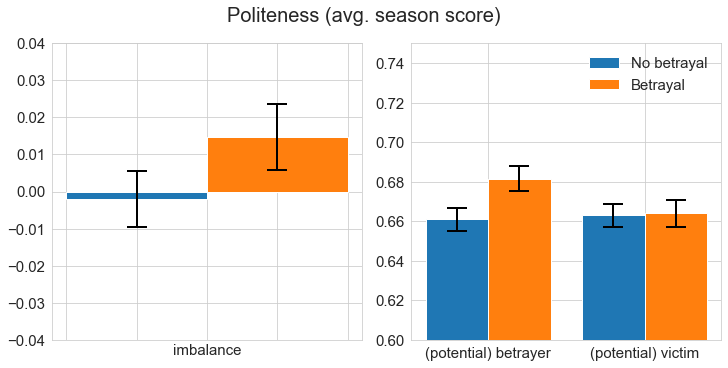

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, constrained_layout=True)
fig.suptitle('Politeness (avg. season score)')

draw_imbalance_plot(ax1, ax2, season_features, 'politeness', (-0.04, 0.04), (0.6, 0.75), True)

We can now look at the support feature. As we can observe in the following figure, there is a difference in the amount of supporting actions between the friendships that ended in betrayal and those that did not. There is less support in the former ones. When looking at the imbalance between (potential) betrayers and victims, it seems higher in friendships that ended in betrayal. However, we should be careful because the standard errors are relatively high.

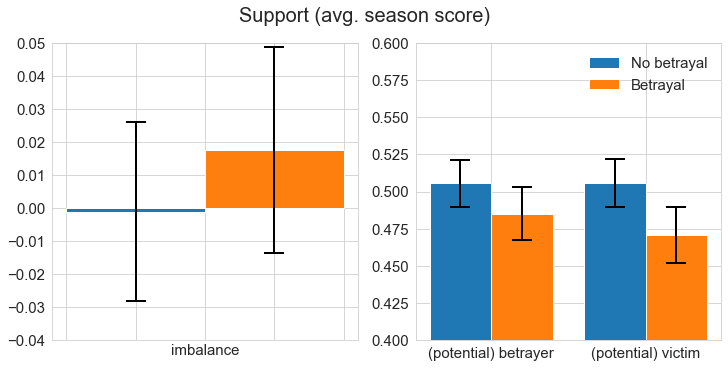

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, constrained_layout=True)
fig.suptitle('Support (avg. season score)')

draw_imbalance_plot(ax1, ax2, season_features, 'support', (-0.04, 0.05), (0.40, 0.6), True)

We can also observe the mean and the variance of this feature at the scale of a player, as represented in the two following figures. 

For the mean feature, we can observe a high imbalance when no betrayal occurs, which tell us that the data may not be correctly randomized between victim and betrayer and that our result might not be very significant. The average number of support does not seem to bring much useful information. \
However, the variance of the support seems more promising with a higher imbalance between betrayer and victim when a betrayal occurs than when it doesn't occur.

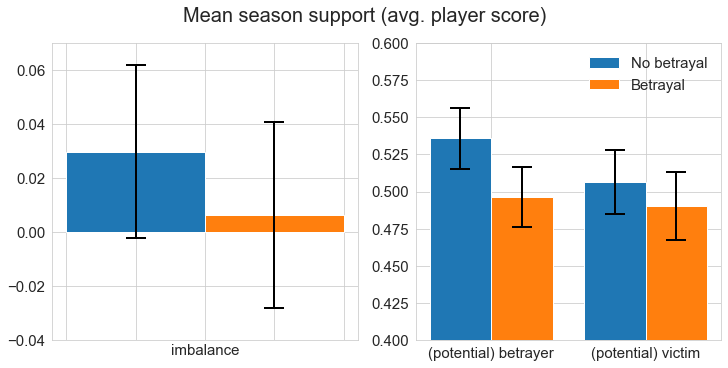

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, constrained_layout=True)
fig.suptitle('Mean season support (avg. player score)')

draw_imbalance_plot(ax1, ax2, friendship_features, 'mean_support', (-0.04, 0.07), (0.4, 0.6), True, 'friendship')

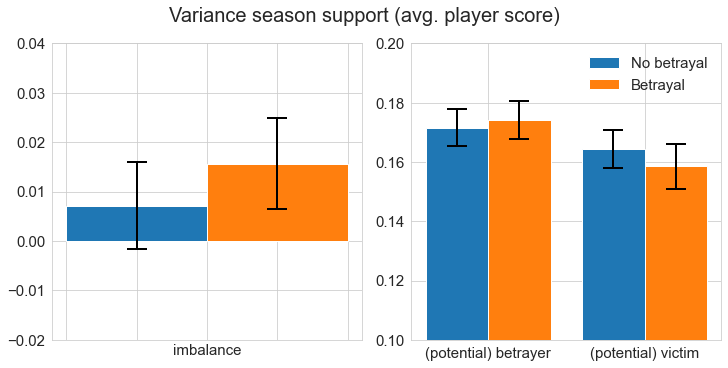

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, constrained_layout=True)
fig.suptitle('Variance season support (avg. player score)')

draw_imbalance_plot(ax1, ax2, friendship_features, 'var_support', (-0.02, 0.04), (0.10, 0.2), True, 'friendship')

## 2.2. Analysis of the friendship features

We computed the cross-correlation of the friendship features to understand how much information each of the features could bring to the classification. 

We can observe that most of the features related to the mean are very correlated with each other, which means that once one of them has been used in the classification, the others will not bring much additional information.The only features that seem less correlated with the others are the politeness, the support and the number of messages. 

We can observe the same dynamic for the variance features but with less correlation. It is very interesting to observe that the variance is not highly correlated with the mean which means that it does bring additional information. 

We can also observe that the victim and the player are not correlated with each others, so they both are interesting.

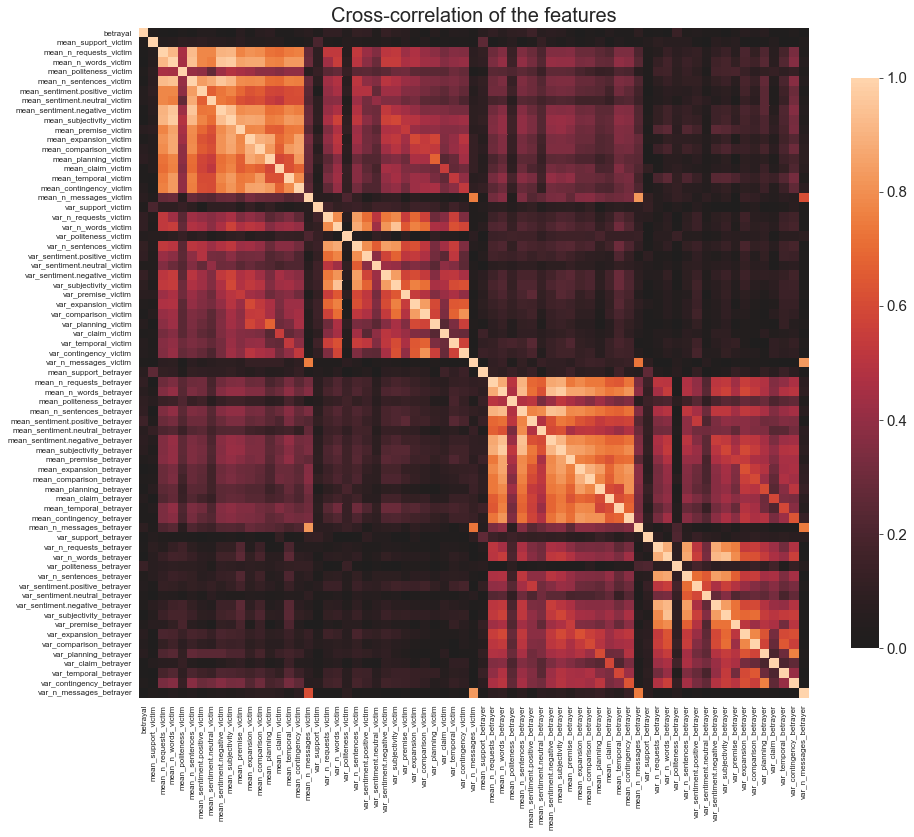

In [12]:
# Compute the absolute cross-correlation between the features as a negative correlation still means a high relation between two features.
corr = final_friendship_features.corr().abs()
# Display the correlation plot in a heatmap
corr_plot(corr, 'Cross-correlation of the features')

A low correlation between our features does not mean that they will be useful for the classification, wo we will now look closely at their direct correlation with the betrayal.

In [13]:
# Take the betrayal correlation of each feature and categorise them for the plots
betrayal_corr = corr.loc[corr.columns[1]:, 'betrayal'].to_frame().reset_index()
betrayal_corr = betrayal_corr.rename(columns={'betrayal' : 'betrayal_correlation'})
betrayal_corr['feature_type'] = 'Mean'
betrayal_corr.loc[betrayal_corr['index'].str.startswith('var'), 'feature_type'] = 'Variance'
betrayal_corr['player'] = 'Victim'
betrayal_corr.loc[betrayal_corr['index'].str.endswith('betrayer'), 'player'] = 'Betrayer'

# We display the top 5 best correlated features
betrayal_corr = betrayal_corr.sort_values(by='betrayal_correlation', ascending=False)
betrayal_corr.head(5)

,index,betrayal_correlation,feature_type,player
39,mean_sentiment.positive_betrayer,0.148994,Mean,Betrayer
54,var_politeness_betrayer,0.138815,Variance,Betrayer
24,var_sentiment.negative_victim,0.119722,Variance,Victim
21,var_n_sentences_victim,0.115844,Variance,Victim
38,mean_n_sentences_betrayer,0.107543,Mean,Betrayer


We plot in the following figure the correlation of the friendship features according to their types (mean or variance). We can observe that the means correlate with the Betrayal event, with a median of 0.04, while the variance correlates with a median of about 0.035. From this analysis it would seem that the variance provides a feature almost as valuable as the mean.

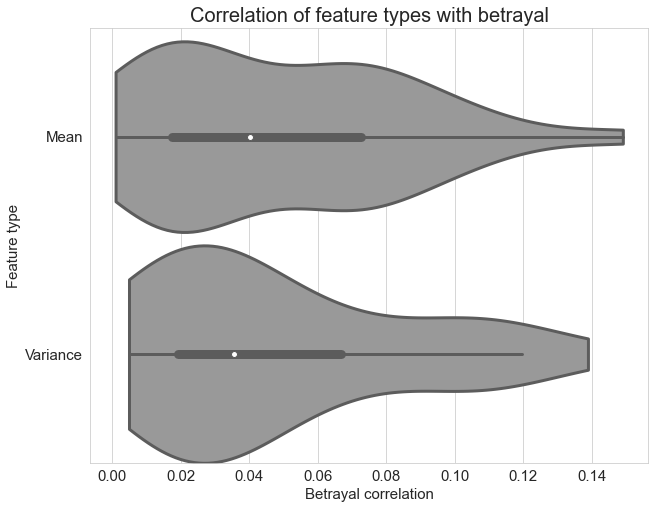

In [14]:
betrayal_corr_plot(betrayal_corr, 'feature_type', 'Feature type', 'Correlation of feature types with betrayal')

From the plot of the correlations of the player types (victim or betrayer) with the betrayal, we can observe that both features related to victims and betrayers are significant to predict betrayal. This corresponds to the statement made in the original paper. 

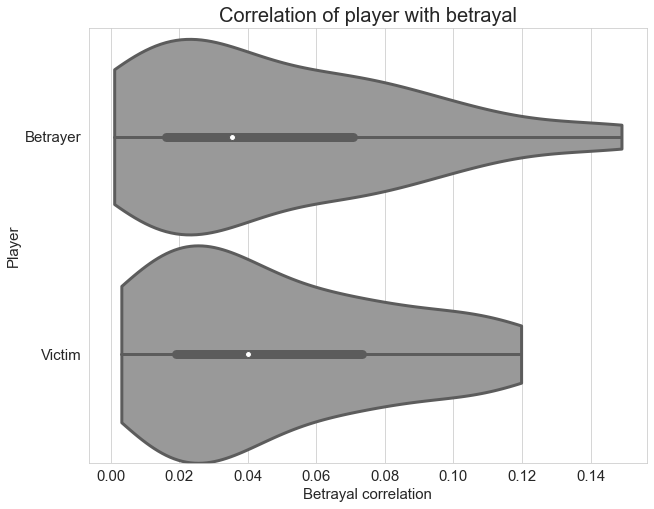

In [15]:
betrayal_corr_plot(betrayal_corr, 'player', 'Player', 'Correlation of player with betrayal')

# 3. Models Training

We selected three different models to train with our dataset and predict betrayal: Logistic Regression (as in the paper), Gradient Boosting Regression and Random Forests. We used 5-fold cross-validation as in the paper to select the model parameters, according to the accuracy. We also tested multiple situations:
- Our two different datasets: the ones of the paper based on season ("paper") and the new ones based on friendship ("friendship").
- With and without feature selection using the two algorithms of the paper: ANOVA and chi2
- Normalization (subtraction of the mean, division by the standard deviation)

Note: the result are displayed in a dataset at the end, the model parameters if relevant with the model are respectively the number of features selected, the number of estimators and the learning rate.

In [16]:
from sklearn.preprocessing import normalize

FEATURES_PAPER = 'paper'
FEATURES_FRIENDSHIP = 'friendship'

# Init the possible values of every situation
features = [FEATURES_PAPER, FEATURES_FRIENDSHIP]
normalize_option = [False, True]
model_types = [MODEL_LOGIT, MODEL_GRADIENT, MODEL_FOREST]
feat_select_types = [None, FEAT_SELECT_ANOVA, FEAT_SELECT_CHI2]

# Init the values selected by cross-validation
nb_features = [5, 10, 20, 30, 50]
n_estimators = [50, 75, 100, 150, 200, 250] # For gradient boosting regressor and random forests
learning_rates = [0.1, 0.05, 0.01] # For gradient boosting regressor

N_FOLDS = 5

# Prepare the result table
result = pd.DataFrame(columns=['Features', 'Normalize', 'Model', 'Feature selection', 'Accuracy', 'Accuracy low ci 95', 'Accuracy high ci 95', 'Model params'])

# Iterate over all situations, train and evaluate the models
for feat in features:
    if feat == FEATURES_PAPER: # Use paper features for training
        X = final_season_features[final_season_features.columns[final_season_features.columns != 'betrayal']]
        y = final_season_features['betrayal']
    elif feat == FEATURES_FRIENDSHIP: # Use new friendship features for training
        X = final_friendship_features[final_friendship_features.columns[final_friendship_features.columns != 'betrayal']]
        y = final_friendship_features['betrayal']
    
    for norm in normalize_option:
        if norm:
            # Normalize the columns if required
            X = pd.DataFrame(normalize(X, axis=0), columns=X.columns)
        for model_type in model_types:
            for feat_select_type in feat_select_types:
                print('Features:', feat, '- Normalize:', norm, '- Model:', model_type, '- Feature selection:', feat_select_type, flush=True)
                acc, low_acc, high_acc, model_params = train_and_evaluate(model_type, feat_select_type, X, y, N_FOLDS, nb_features, n_estimators, learning_rates)
                result = result.append({'Features' : feat, 'Normalize' : norm, 'Model' : model_type, 'Feature selection' : feat_select_type, 'Accuracy' : acc, 'Accuracy low ci 95' : low_acc, 'Accuracy high ci 95' : high_acc, 'Model params' : model_params}, ignore_index=True)
result

Features: paper - Normalize: False - Model: logit - Feature selection: None


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.88s/it]

Features: paper - Normalize: False - Model: logit - Feature selection: anova



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.37s/it]

Features: paper - Normalize: False - Model: logit - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.72s/it]

Features: paper - Normalize: False - Model: gradient - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:50<00:00, 58.09s/it]

Features: paper - Normalize: False - Model: gradient - Feature selection: anova



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [14:07<00:00, 169.58s/it]

Features: paper - Normalize: False - Model: gradient - Feature selection: chi2



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [14:06<00:00, 169.24s/it]

Features: paper - Normalize: False - Model: forest - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:37<00:00, 31.43s/it]

Features: paper - Normalize: False - Model: forest - Feature selection: anova



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:08<00:00, 121.73s/it]

Features: paper - Normalize: False - Model: forest - Feature selection: chi2



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [08:41<00:00, 104.33s/it]


Features: paper - Normalize: True - Model: logit - Feature selection: None


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.43s/it]

Features: paper - Normalize: True - Model: logit - Feature selection: anova



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.77s/it]

Features: paper - Normalize: True - Model: logit - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]

Features: paper - Normalize: True - Model: gradient - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:46<00:00, 33.20s/it]

Features: paper - Normalize: True - Model: gradient - Feature selection: anova



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:47<00:00, 129.54s/it]

Features: paper - Normalize: True - Model: gradient - Feature selection: chi2



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [10:32<00:00, 126.53s/it]

Features: paper - Normalize: True - Model: forest - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.91s/it]

Features: paper - Normalize: True - Model: forest - Feature selection: anova



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [08:32<00:00, 102.42s/it]

Features: paper - Normalize: True - Model: forest - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [08:10<00:00, 98.18s/it]

Features: friendship - Normalize: False - Model: logit - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.22it/s]

Features: friendship - Normalize: False - Model: logit - Feature selection: anova



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.79it/s]

Features: friendship - Normalize: False - Model: logit - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.77it/s]

Features: friendship - Normalize: False - Model: gradient - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:37<00:00, 31.45s/it]

Features: friendship - Normalize: False - Model: gradient - Feature selection: anova



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:28<00:00, 65.66s/it]

Features: friendship - Normalize: False - Model: gradient - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:32<00:00, 66.40s/it]

Features: friendship - Normalize: False - Model: forest - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:15<00:00, 15.17s/it]

Features: friendship - Normalize: False - Model: forest - Feature selection: anova



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:17<00:00, 39.57s/it]

Features: friendship - Normalize: False - Model: forest - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:16<00:00, 39.31s/it]

Features: friendship - Normalize: True - Model: logit - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.89it/s]

Features: friendship - Normalize: True - Model: logit - Feature selection: anova



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.80it/s]

Features: friendship - Normalize: True - Model: logit - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.02it/s]

Features: friendship - Normalize: True - Model: gradient - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:36<00:00, 31.29s/it]

Features: friendship - Normalize: True - Model: gradient - Feature selection: anova



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:31<00:00, 66.38s/it]

Features: friendship - Normalize: True - Model: gradient - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:14<00:00, 62.82s/it]

Features: friendship - Normalize: True - Model: forest - Feature selection: None



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:08<00:00, 13.66s/it]

Features: friendship - Normalize: True - Model: forest - Feature selection: anova



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.10s/it]

Features: friendship - Normalize: True - Model: forest - Feature selection: chi2



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:08<00:00, 37.64s/it]


,Features,Normalize,Model,Feature selection,Accuracy,Accuracy low ci 95,Accuracy high ci 95,Model params
0,paper,False,logit,None,0.517419,0.494839,0.543226,[all]
1,paper,False,logit,anova,0.529677,0.500000,0.560000,[20]
2,paper,False,logit,chi2,0.529677,0.512839,0.543226,[5]
3,paper,False,gradient,None,0.542581,0.510968,0.574194,"[all, 50, 0.01]"
4,paper,False,gradient,anova,0.561290,0.535468,0.590323,"[5, 50, 0.01]"
5,paper,False,gradient,chi2,0.565161,0.530968,0.601290,"[5, 50, 0.01]"
6,paper,False,forest,None,0.515484,0.497419,0.533548,"[all, 150]"
7,paper,False,forest,anova,0.537419,0.514839,0.552274,"[10, 100]"
8,paper,False,forest,chi2,0.542581,0.534194,0.550968,"[5, 250]"
9,paper,True,logit,None,0.517419,0.494839,0.546452,[all]


We can observe from the above table that a model type does not improve the accuracy scores significantly in every situation, but the Gradient Boosting Regressor seems more relevant for the features of the paper.

However, using means and variances of the features over the friendships improves the scores as compared to only using the features over the seasons as it is done in the paper. For example, the logistic regression model gives 52.97% accuracy with the paper's features, and 59.67% accuracy when using our new friendship features.

It can be noted that we did not manage to reproduce the paper's result of 57% accuracy for logistic regression.

We see in the following table that globally the Gradient Boosting Regressor and the Random Forest models performs better than the Logistic Regression. The Gradient Boosting Regressor seems to be slightly better than the Random Forest model in average, but as explained above it depends on the situation.

In [30]:
# Compute the accuracy stats of the features selection algorithm
result.groupby('Model', dropna=False)['Accuracy'].agg(['mean', 'std'])

,mean,std
Model,,
forest,0.562097,0.033688
gradient,0.568338,0.015743
logit,0.552262,0.030828


In the following table, we see that the friendship features clearly allow for a better classification than the paper features based on seasons.

In [31]:
# Compute the accuracy stats of the features
result.groupby('Features', dropna=False)['Accuracy'].agg(['mean', 'std'])

,mean,std
Features,,
friendship,0.584020,0.013892
paper,0.537778,0.016653


We see in the following table that doing feature selection is important, but that the choice of the algorithm used does not impact the accuracy of the classification.

In [52]:
# Compute the accuracy stats of the features selection algorithm
feat_select_alg_result = result.groupby('Feature selection', dropna=False)['Accuracy'].agg(['mean', 'std'])
indices = feat_select_alg_result.index.tolist()
indices[2] = 'None'
feat_select_alg_result.index = indices
feat_select_alg_result

,mean,std
anova,0.565407,0.027984
chi2,0.568855,0.027252
None,0.548435,0.026266


In the following table, we see that the normalization does not improve the results in our situation.

In [32]:
# Compute the accuracy stats of the features selection algorithm
result.groupby('Normalize', dropna=False)['Accuracy'].agg(['mean', 'std'])

,mean,std
Normalize,,
False,0.561503,0.029176
True,0.560295,0.027393


# Conclusion

We can confirm, based on the accuracy rates we achieved, the general conclusion that the authors of the paper came to: "the intention to betray can leak through the language one uses". 

Regarding our own extensions, we found that parsing the dataset by friendship rather than by season has its advantages. This way of treating the data gave us access to a new feature: the support between the players within a friendship. We found that this feature does indeed provide information about the destiny of a relationship. Furthermore, when using friendships as a basis for approaching the data, it is interesting to note that the variances as well as the means are very useful features. 

Finally, in the beginning of this project one of the things that we set out to explore was whether the use of different machine learning models could improve the prediction results achieved. Our work would lead us to say that using the features from the paper, a Gradient Boosting Regressor model achieves better results than Logistic Regression. 

However, our best result was of 60.07% accuracy, using the additional features that we engineered and a Random Forest model. This lets us think that the choice of the model is of less significant importance than the choice of the features when trying to improve the accuracy of the predictions.